In [10]:
import numpy as np
import os
from collections import defaultdict
import networkx as nx
from tqdm import tqdm

In [11]:
with open('data/train.tsv') as f:
    lines = f.readlines()
    cids = [int(line.split('\t')[0]) for line in lines]

In [12]:
embedding = np.load("data/token_embedding_dict.npy", allow_pickle=True)[()]
atom_count = defaultdict(int)

for cid in tqdm(cids):
    with open(f'data/raw/{cid}.graph') as f:
        txt = f.readlines()
        ids = txt[txt.index('\n') + 2 : ]
        ids = list(map(lambda x: int(x.split(' ')[1][:-1]), ids))
        for id in ids:
            atom_count[id] += 1


sorted_cnt = sorted(atom_count.items(), reverse=True, key=lambda k_v: k_v[1])
tot = sum(atom_count.values())
atom_label = { k: f'{k}\n{100*v/tot:.2f}%' for k, v in sorted_cnt }
for k, v in sorted_cnt[:20]:
    print(f'{v}  {k}')

  5%|▍         | 1286/26408 [00:00<00:01, 12849.41it/s]

100%|██████████| 26408/26408 [00:01<00:00, 17875.13it/s]

69428  1510461303
33715  266675433
33263  1510328189
29995  951226070
27529  675765711
14801  2667063169
12752  530246988
11824  98513984
11735  1916236386
11257  1167322652
10956  994485099
10441  10565946
10421  1535166686
9979  3545365497
9584  1286704427
9177  954800030
8714  2235918822
8686  3542456614
8268  1542633699
8252  1861965050


In [13]:
unk = 0
for atom in atom_count:
    if str(atom) not in embedding:
        unk += atom_count[atom]
unk / tot

0.004592013227249541

In [32]:
def read_graph(cid):
    with open(f'data/raw/{cid}.graph') as f:
        f.readline()
        line = f.readline()[:-1]
        G = nx.Graph()
        while line != '':
            u, v = line.split(' ')
            u, v = f'{cid}_{u}', f'{cid}_{v}'
            G.add_edge(u, v)
            line = f.readline()[:-1]
        
        f.readline()
        G_labels = {}
        line = f.readline()[:-1]
        while line != '':
            id, atom = list(map(int, line.split(' ')))
            G_labels[f'{cid}_{id}'] = atom % 1000
            line = f.readline()[:-1]
        return G, G_labels


def show_mol(cid):
    G, G_labels = read_graph(cid)
    pos = nx.planar_layout(G)
    pos = nx.spring_layout(G, pos=pos)
    nx.draw(G, pos=pos, labels=G_labels, with_labels=True, font_size=9, node_color='white')

In [31]:
G = nx.Graph()
G_atom = {}

for cid in tqdm(cids):
    with open(f'data/raw/{cid}.graph') as f:
        f.readline()
        line = f.readline()[:-1]
        while line != '':
            u, v = line.split(' ')
            u, v = f'{cid}_{u}', f'{cid}_{v}'
            G.add_edge(u, v)
            line = f.readline()[:-1]
        
        f.readline()
        line = f.readline()[:-1]
        while line != '':
            id, atom = list(map(int, line.split(' ')))
            G_atom[f'{cid}_{id}'] = atom
            line = f.readline()[:-1]

print(G)

100%|██████████| 26408/26408 [00:05<00:00, 4465.92it/s]


Graph with 850859 nodes and 887089 edges


In [17]:
cycle_occ = defaultdict(list)
for cycle in tqdm(nx.cycle_basis(G)):
    atoms = list(map(lambda u: G_atom[u], cycle))

    start_index1, _ = min(enumerate(atoms), key=lambda x: x[1])
    atoms1 = atoms[start_index1:] + atoms[:start_index1]

    atoms_rev = atoms[::-1]
    start_index2, _ = min(enumerate(atoms_rev), key=lambda x: x[1])
    atoms2 = atoms_rev[start_index1:] + atoms_rev[:start_index1]

    atoms = min(atoms1, atoms2)
    cid = int(cycle[0].split('_')[0])
    cycle_occ[tuple(atoms)].append(cid)

# sorted_cycle_occ = list(sorted(cycle_occ.items(), reverse=True, key=lambda x: len(x[1])))
sorted_cycle_occ = list(sorted(cycle_occ.items(), reverse=True, key=lambda x: len(set(x[1]))))


100%|██████████| 62967/62967 [00:00<00:00, 192808.94it/s]


In [18]:
all_occs = set()
for cycle, occ in sorted_cycle_occ[:20]:
    unique_occ = set(occ)
    all_occs.update(unique_occ)
    print(f'cumul {len(all_occs)*100/26408:.1f}%    {len(unique_occ)*100/26408:.1f}%    ex {list(sorted(occ))[:5]}    {cycle}')

# 6 liaisons simple 1 O
# 4 ls 1 ld 2 N
# 3 ls 3 ld 2 N
# 5 ls 1 O
# 3 ls 3 ld (benzene)
    
# DUP 6 ls 1 O
# DUP 6 ls 1 O
# DUP 6 ls 1 O
# DUP 5 ls 1 O
# DUP 5 ls 1 O

#19 

cumul 5.7%    5.7%    ex [5988, 6032, 6072, 7314, 7427]    (675765711, 675765711, 675765711, 1286704427, 2667063169, 1916236386)
cumul 11.1%    5.4%    ex [5270, 5884, 5885, 5886, 5957]    (540046244, 1100037548, 3176806076, 553412256, 934550081)
cumul 11.4%    5.1%    ex [5270, 5884, 5885, 5886, 5893]    (553412256, 1100037548, 725322217, 1100037548, 1445852595, 3176806076)
cumul 11.4%    3.2%    ex [10214, 10663, 41211, 87642, 92133]    (675765711, 954800030, 1916236386, 2667063169, 3109000344)
cumul 13.4%    2.0%    ex [107, 997, 999, 1001, 2000]    (98513984, 98513984, 98513984, 951226070, 4121755354, 951226070)
cumul 14.6%    1.7%    ex [65369, 83489, 114627, 119245, 119258]    (675765711, 675765711, 675765711, 1286704427, 2667063169, 2640800466)
cumul 15.7%    1.5%    ex [19649, 23267, 23700, 83279, 112084]    (675765711, 675765711, 1916236386, 2667063169, 1286704427, 2584514126)
cumul 16.0%    1.5%    ex [66535, 92753, 164800, 165620, 444878]    (675765711, 3109000344, 266706316

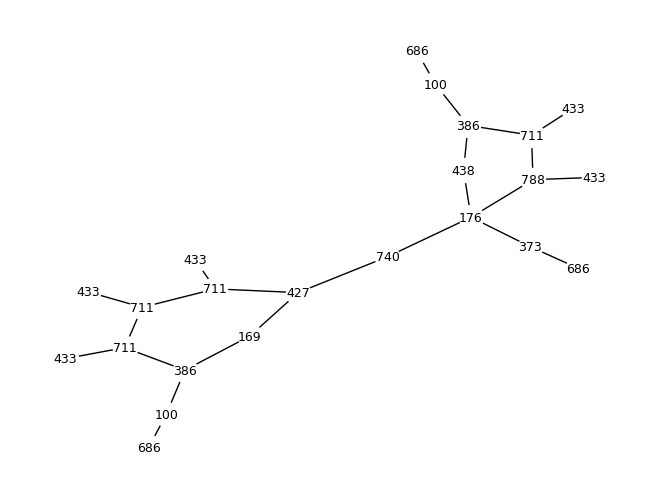

In [33]:
show_mol(5988)

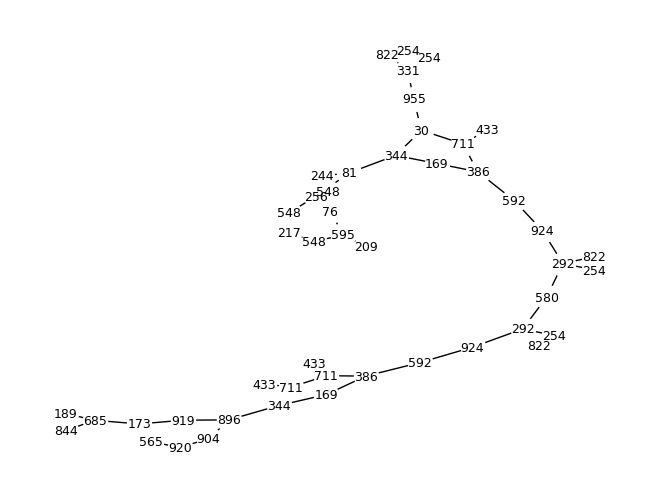

In [34]:

show_mol(5884)

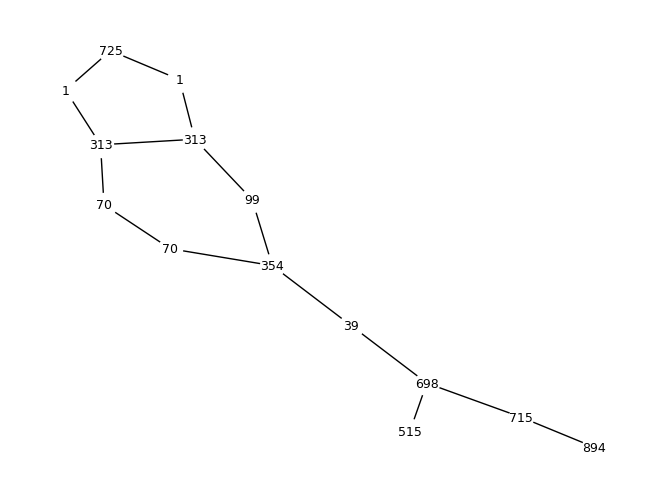

In [35]:
show_mol(1615)

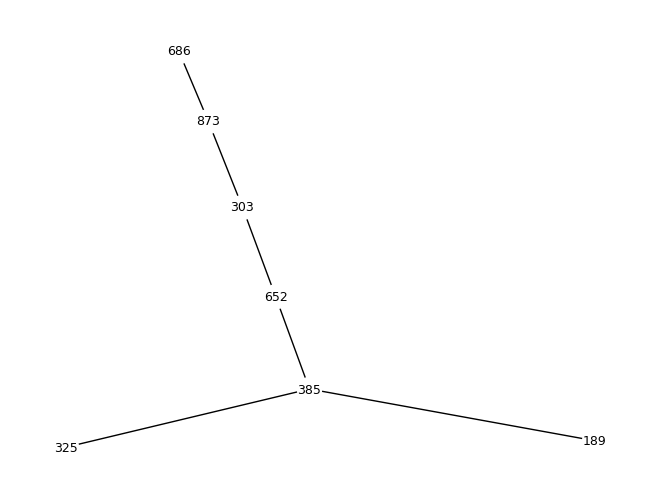

In [36]:
show_mol(10413)

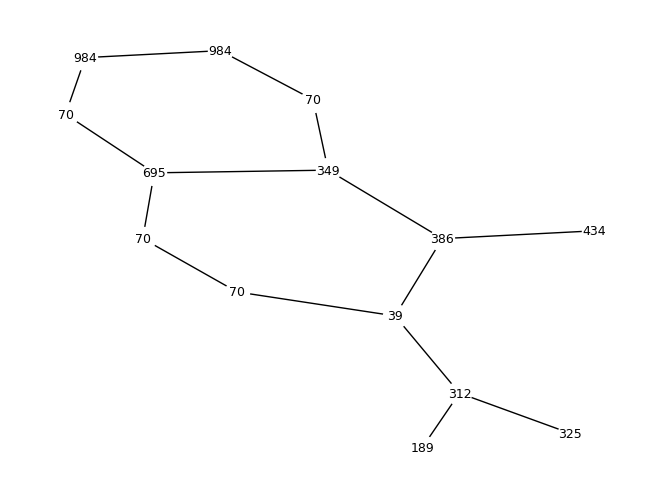

In [37]:
show_mol(6844)